In [28]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [29]:
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/match_team_player_complete.csv')
for e in range(3, len(df.columns)): #iterate for each column
    num = df.iloc[:, e].max() #check the maximum value in each column
    if num < 10:
        df.iloc[:, e] /= 10
    elif num < 100:
        df.iloc[:, e] /= 100
    elif num < 1000:
        df.iloc[:, e] /= 1000
    else:
        print("Error in normalization! Please check!")
#convert labels to numbers
df['labels'] = df['outcome'].map(
    {'H': 0, 'A': 1, 'D': 2})
df = df.drop(["outcome"], axis = 1)
df = df.drop(["stage"], axis = 1)
df = df.drop(["home_team_goal"], axis = 1)
df = df.drop(["away_team_goal"], axis = 1)

df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,match_id,home_buildUpPlaySpeed,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,home_buildUpPlayDribblingClass,home_buildUpPlayPositioningClass,home_chanceCreationPositioningClass,home_defenceDefenderLineClass,away_buildUpPlayDribblingClass,away_buildUpPlayPositioningClass,away_chanceCreationPositioningClass,away_defenceDefenderLineClass,home_overall_rating_1,home_overall_rating_2,home_overall_rating_3,home_overall_rating_4,home_overall_rating_5,home_overall_rating_6,home_overall_rating_7,home_overall_rating_8,home_overall_rating_9,home_overall_rating_10,home_overall_rating_11,away_overall_rating_1,away_overall_rating_2,away_overall_rating_3,away_overall_rating_4,...,home_gk_reflexes_6,home_gk_reflexes_7,home_gk_reflexes_8,home_gk_reflexes_9,home_gk_reflexes_10,home_gk_reflexes_11,away_gk_reflexes_1,away_gk_reflexes_2,away_gk_reflexes_3,away_gk_reflexes_4,away_gk_reflexes_5,away_gk_reflexes_6,away_gk_reflexes_7,away_gk_reflexes_8,away_gk_reflexes_9,away_gk_reflexes_10,away_gk_reflexes_11,home_height_1,home_height_2,home_height_3,home_height_4,home_height_5,home_height_6,home_height_7,home_height_8,home_height_9,home_height_10,home_height_11,away_height_1,away_height_2,away_height_3,away_height_4,away_height_5,away_height_6,away_height_7,away_height_8,away_height_9,away_height_10,away_height_11,labels
0,665739,0.45,0.35,0.70,0.45,0.55,0.65,0.60,0.70,0.45,0.45,0.50,0.35,0.60,0.70,0.65,0.70,0.1,0.2,0.2,0.1,0.1,0.2,0.2,0.1,0.70,0.67,0.66,0.65,0.65,0.65,0.64,0.64,0.64,0.63,0.63,0.70,0.70,0.70,0.68,...,0.21,0.21,0.20,0.20,0.20,0.20,0.63,0.23,0.23,0.23,0.22,0.21,0.21,0.21,0.20,0.20,0.20,0.19304,0.19050,0.18796,0.18542,0.18542,0.18288,0.18288,0.18288,0.17780,0.17780,0.17780,0.19812,0.18796,0.18542,0.18542,0.18542,0.18288,0.18288,0.18288,0.18034,0.17780,0.17526,0
1,665741,0.65,0.60,0.50,0.40,0.50,0.60,0.70,0.60,0.50,0.60,0.50,0.50,0.50,0.60,0.60,0.65,0.1,0.2,0.2,0.1,0.1,0.2,0.2,0.1,0.67,0.66,0.66,0.66,0.65,0.65,0.63,0.62,0.62,0.62,0.57,0.67,0.67,0.66,0.66,...,0.20,0.20,0.20,0.20,0.20,0.20,0.71,0.25,0.23,0.23,0.23,0.23,0.23,0.22,0.21,0.20,0.20,0.19304,0.18796,0.18796,0.18288,0.18288,0.18034,0.17780,0.17780,0.17780,0.17526,0.17526,0.19050,0.18796,0.18796,0.18796,0.18288,0.18288,0.18034,0.18034,0.18034,0.17780,0.17526,2
2,665745,0.50,0.35,0.70,0.50,0.60,0.70,0.50,0.70,0.45,0.45,0.50,0.35,0.60,0.70,0.65,0.70,0.1,0.2,0.2,0.1,0.1,0.2,0.2,0.1,0.77,0.74,0.74,0.73,0.72,0.72,0.71,0.71,0.71,0.70,0.66,0.70,0.70,0.68,0.67,...,0.21,0.20,0.20,0.20,0.20,0.10,0.70,0.23,0.23,0.23,0.22,0.21,0.21,0.21,0.20,0.20,0.20,0.19304,0.19304,0.19050,0.18796,0.18796,0.18542,0.18542,0.18288,0.18034,0.17780,0.16764,0.18796,0.18542,0.18542,0.18542,0.18288,0.18288,0.18288,0.18034,0.17780,0.17526,0.17272,0
3,665749,0.65,0.60,0.60,0.40,0.50,0.70,0.60,0.70,0.53,0.40,0.55,0.55,0.65,0.70,0.70,0.65,0.1,0.2,0.2,0.1,0.1,0.2,0.2,0.1,0.74,0.69,0.68,0.67,0.67,0.66,0.65,0.64,0.64,0.64,0.64,0.78,0.75,0.73,0.73,...,0.23,0.22,0.22,0.21,0.21,0.21,0.72,0.25,0.23,0.22,0.22,0.22,0.21,0.21,0.20,0.20,0.20,0.19050,0.18542,0.18542,0.18542,0.18288,0.18288,0.17780,0.17780,0.17780,0.17780,0.17526,0.19304,0.19050,0.19050,0.19050,0.18796,0.18796,0.18542,0.18288,0.18034,0.17780,0.17526,2
4,665763,0.45,0.45,0.50,0.35,0.60,0.70,0.65,0.70,0.50,0.60,0.50,0.50,0.50,0.60,0.60,0.65,0.1,0.2,0.2,0.1,0.1,0.2,0.2,0.1,0.68,0.67,0.67,0.66,0.65,0.65,0.64,0.63,0.63,0.62,0.62,0.67,0.67,0.66,0.66,...,0.21,0.21,0.21,0.21,0.20,0.20,0.71,0.25,0.23,0.23,0.23,0.23,0.23,0.22,0.21,0.20,0.20,0.18542,0.18542,0.18542,0.18288,0.18288,0.18288,0.18034,0.17780,0.17526,0.17526,0.17018,0.19050,0.18796,0.18796,0.18796,0.18288,0.18288,0.18034,0.18034,0.18034,0.17780,0.17526,2
...,...,...,...,...,...,...,...,...,...,...

In [30]:
test_points = pd.read_csv("/content/drive/My Drive/Soccer/test_points.csv")
new_test = df.loc[df['match_id'].isin(test_points.iloc[:, 1].values.tolist())]
new_train = df.drop(df[df['match_id'].isin(test_points.iloc[:, 1].values.tolist())].index)

In [40]:
#Dataloader

X = new_train.iloc[:, 0:-1]#.values  # Input values
y = new_train.iloc[:, -1]#.values    # Label values

X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y,  test_size=0.04, random_state=42)

X_test_30 = pd.concat([X_test_pd, new_test.iloc[:, :-1]], ignore_index = True)
y_test_30 = pd.concat([y_test_pd, new_test.iloc[:, -1]], ignore_index = True)


X_train = torch.FloatTensor(X_train_pd.values[:, 1:])
y_train = torch.LongTensor(y_train_pd.values)
X_test = torch.FloatTensor(X_test_30.values[:, 1:])
y_test = torch.LongTensor(y_test_30.values)


matchID_train = X_train_pd.iloc[:,0].values
matchID_test = X_test_30.iloc[:,0].values

In [41]:
class soccerData(Dataset):
    def __init__(self, data):
      x = df.iloc[:, 3:-1].values
      y = df.iloc[:, -1].values

      sc = StandardScaler()
      x_train = sc.fit_transform(x)
      y_train = y

      self.X_train = torch.tensor(x_train, dtype = torch.float32)
      self.Y_train = torch.tensor(y_train)

      def __len__(self):
        return len(self.y_train)

      def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [42]:
class NeuralNet(nn.Module):
    
    def __init__(self, in_features=832, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=512)
        self.fc2 = nn.Linear(in_features=512, 
                             out_features=256)
        self.fc3 = nn.Linear(in_features=256,  
                             out_features=128)
        self.fc4 = nn.Linear(in_features=128,  
                             out_features=32)
        self.fc5 = nn.Linear(in_features=32,  
                             out_features=out_features)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        return self.fc5(X)

In [47]:
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []
for i in range(epochs):
    i += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    accuracy_train.append(correct.item()/y_train.shape[0])
    loss_train.append(loss)
    
    with torch.no_grad():
      y_pred_test = model(X_test)

      preds = torch.max(y_pred_test, dim=1)[1]

      correct_test = (preds == y_test).sum()
      test_l = criterion(y_pred_test, y_test)
      
      loss_test.append(test_l)
      accuracy_test.append(correct_test.item() / y_test.shape[0])

    if i % 10 == 0:
        print(f'epoch: {i} -> loss: {loss}')

    
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 10 -> loss: 1.0696306228637695
epoch: 20 -> loss: 1.0622155666351318
epoch: 30 -> loss: 1.0541398525238037
epoch: 40 -> loss: 1.0221812725067139
epoch: 50 -> loss: 1.020042061805725
epoch: 60 -> loss: 1.0218569040298462
epoch: 70 -> loss: 1.0004606246948242
epoch: 80 -> loss: 0.9904304146766663
epoch: 90 -> loss: 0.9891282320022583
epoch: 100 -> loss: 0.9867596626281738
epoch: 110 -> loss: 0.9848284125328064
epoch: 120 -> loss: 0.9879265427589417
epoch: 130 -> loss: 0.9852637648582458
epoch: 140 -> loss: 0.9832381010055542
epoch: 150 -> loss: 0.984872579574585
epoch: 160 -> loss: 0.9836225509643555
epoch: 170 -> loss: 0.9812905788421631
epoch: 180 -> loss: 0.9804301261901855
epoch: 190 -> loss: 0.9803197979927063
epoch: 200 -> loss: 0.9795012474060059
epoch: 210 -> loss: 0.9814412593841553
epoch: 220 -> loss: 0.9827672243118286
epoch: 230 -> loss: 0.9797200560569763
epoch: 240 -> loss: 0.9788002371788025
epoch: 250 -> loss: 0.980442464351654
epoch: 260 -> loss: 1.036177992820739

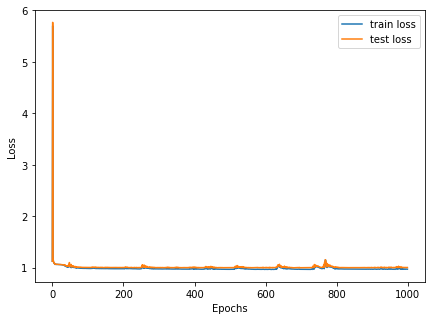

In [56]:
plt.figure(figsize=(7, 5))
plt.plot(loss_train, label = "train loss")
plt.plot(loss_test, label = "test loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

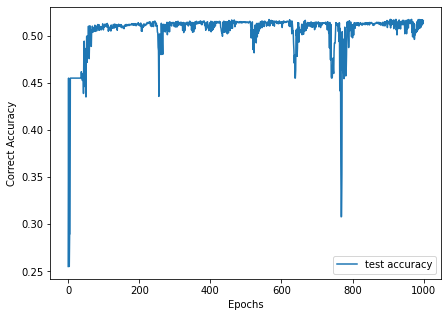

In [59]:
plt.figure(figsize=(7, 5))
plt.plot(accuracy_test, label = "test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Correct Accuracy')
plt.legend()
plt.show()

In [52]:
with torch.no_grad():
    
    y_pred = model(X_test)
    preds = torch.max(y_pred, dim=1)[1]
    correct = (preds == y_test).sum()
    
print(f'{correct} out of {y_test.shape[0]} is correct : {correct.item() / y_test.shape[0] * 100}%')

2488 out of 4844 is correct : 51.362510322047896%


In [13]:
m = nn.Softmax(dim = 1)
y_pred_softmax = m(y_pred).numpy()

matchID_test_reshape = matchID_test.reshape((-1, 1))
matchID_test_reshape
predictions = np.hstack((matchID_test_reshape, y_pred_softmax))

In [14]:
np.savetxt('/content/drive/My Drive/Soccer/predictions3.csv', predictions, delimiter=',')